# 04. Modeling #
---

We are trying to identify if our tweet contains information on road closures. In order to train and test our model we have formed a dataset of historic tweets from various accounts related to transport situations - the process has been detailed in a notebook [01 Twitter Scraping](http://localhost:8888/notebooks/PROJECTS/project_5/project_5/codes/01%20Twitter_Scraping.ipynb). We have labeled this data basing on their relevance and constructed the dataset [final_df.csv](http://localhost:8888/edit/PROJECTS/project_5/project_5/datasets/final_df.csv) for future modeling. This process is described in a notebook [02 Pre-processing and EDA](http://localhost:8888/notebooks/PROJECTS/project_5/project_5/codes/02%20Pre-processing%20and%20EDA.ipynb).

## Table of Contents ##
---

- [1. Importing Modules and Data](#1.-Importing-Modules-and-Data)
- [2. Baseline Model](#2.-Baseline-Model)
- [3. Modeling](#3.-Modeling)
    - [3.1 Logistic Regression](#3.1-Logistic-Regression)
    - [3.2 Naive Bayes Model](#3.2-Naive-Bayes-Model)
    - [3.3 Decision Trees](#3.3-Decision-Trees)
    - [3.4 Bagging Classifier](#3.4-Bagging-Classifier)
    - [3.5 Random Forest](#3.5-Random-Forest)
    - [3.6 Extra Tree Classifier](#3.6-Extra-Tree-Classifier)
- [4. Conclusions](#4.-Conclusions)
- [5. Test Run](#5.-Test-Run)

## 1. Importing Modules and Data ##
---

In [1]:
#Importing necessary modules
import pandas as pd
import numpy as np
import requests
import time
from sklearn.pipeline                import Pipeline
from sklearn.model_selection         import train_test_split, GridSearchCV
from sklearn.linear_model            import LogisticRegression
from sklearn.ensemble                import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction      import stop_words
from sklearn.naive_bayes             import GaussianNB, MultinomialNB
from sklearn.tree                    import DecisionTreeClassifier

import warnings

In [2]:
#Re-setting future updates warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#Reading our data from a .csv file 
df = pd.read_csv('../datasets/modeling_df.csv')

#Initial data check
df.head()

,Unnamed: 0,index,tweet,mark
0,0,3,Crash on I-295 southbound South of Exit 29 - U...,0
1,1,4,"Construction, bridge painting on Atlantic City...",0
2,2,8,Roadwork on New Jersey Turnpike inner roadway ...,0
3,3,9,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,0
4,4,19,Roadwork on New Jersey Turnpike inner roadway ...,0


In [4]:
#Checking Data Frame's columns
df.columns

Index(['Unnamed: 0', 'index', 'tweet', 'mark'], dtype='object')

In [5]:
df = df[df['tweet'].notna()]

In [6]:
#Forming our features matrix and target value
X = df['tweet'] #Features matrix
y = df['mark'] #Target value

## 2. Baseline Model ##
---

In order to set our comparison base we need to define our model evaluation criteria and define the baseline model. For the sake of simplicity we decided to use accuracy as the basic evaluator for our classification models. Also, accuracy seems to be the most logical criteria as we are aiming at identifying our "pozitive" tweets as tweets with actual road closure information. Hence, we do not really need to work with the false positives (they will be eliminated as not having any valuable information at later stages), as well as false negatives (we are using a bunch of twitter channels, and they have similar information - hence our chances of missing relevant information are relatively small). 

In [7]:
#Revising our target value dispersion
y.value_counts()

1    1622
0    1622
Name: mark, dtype: int64

In [8]:
#Defining our baseline model accuracy
baseline_accuracy = y.value_counts()[1]/(y.shape[0])
baseline_accuracy

0.5

Hence, we are going to look for accuracy improvements in comparison with our baseline model accuracy of 0.5 (or 50%).

## 3. Modeling ##
---

Let's try several classifications models along with the model tuning techniques. 

## 3.1 Logistic Regression ##

The first model to try is Logistic Regression Classificator. It's a natural choice for a classification problem, as the model and it's coefficients are very interpretable, and we aslo could normally expect quite satisfactory and stable model's performance. 

In [9]:
#Splitting our dataset on training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

#Instantiating a pipeline for CountVectorizer
pipe_cvec = Pipeline(steps = [('vectorizer', CountVectorizer()), 
                        ('model', LogisticRegression())])

#Setting grid search parameters
hyperparams_cvec = {'vectorizer__max_features':[1000,2500,5000],
                    'vectorizer__ngram_range':[(1,1),(2,2),(1,2), (1,3),(2,3),(3,3)],
                    'vectorizer__stop_words':[None, 'english']
                   }

#Instantiating a pipeline for TF-IDF Vectorizer
pipe_tfidf = Pipeline(steps = [('vectorizer', TfidfVectorizer()), 
                        ('model', LogisticRegression())])

#Setting grid search parameters
hyperparams_tfidf = {'vectorizer__max_features':[1000,2500,5000],
                    'vectorizer__ngram_range':[(1,1),(2,2),(1,2), (1,3),(2,3),(3,3)],
                    'vectorizer__stop_words':[None, 'english'],
                   }
#Instantiating grid search with 3-fold cross-validation
gs_cvec = GridSearchCV(pipe_cvec,
                      hyperparams_cvec,
                      cv=3,
                       n_jobs=-1)
gs_tfidf = GridSearchCV(pipe_tfidf,
                       hyperparams_tfidf,
                       cv=3,
                       n_jobs=-1)

#Fitting grid search
results_cvec = gs_cvec.fit(X_train,y_train)
results_tfidf = gs_tfidf.fit(X_train,y_train)

In [10]:
#Best accuracy score for a CountVectorizer pipeline
results_cvec.best_score_

0.9942457870941225

In [11]:
#Best accuracy on the training set for a CountVectorizer pipeline
results_cvec.score(X_train,y_train)

0.9995889847924373

In [12]:
#Best accuracy score for a TD-IDF pipeline
results_tfidf.best_score_ 

0.979449239621866

In [13]:
#Best accuracy on the training set for a TF-IDF pipeline
results_tfidf.score(X_train,y_train)

0.9921907110563091

In [14]:
#Our best Logistic Regression model's parameters 
results_cvec.best_estimator_

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=2500, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
             

As we could see, the Logistic Regression model with CountVectorizer performs quite well with a testing set score of 

In [15]:
round(results_cvec.score(X_train,y_train),4)

0.9996

on a training set, and with 

In [16]:
round(results_cvec.best_score_, 4)

0.9942

on a testing set. These scores indicate a stable and well-balanced model with great potential for generalizing.

In order to solidify our findings, let's try some more advanced models in order to improve accuracy.

We should chose using CountVectorizer for the future models as it's algoritm fits our purpose of filtering tweets with closure information better - we still need a tweet with many 'close' stems repetitions, while it might be penalized by Tf-idf. 

In [17]:
#Initializing a dictionary to store model scores
scores = {}

#Adding our scores
scores.update({'LR_cvec':[round(results_cvec.score(X_train,y_train),4)*100, round(results_cvec.best_score_, 4)*100 ]})
scores

{'LR_cvec': [99.96000000000001, 99.42]}

## 3.2 Naive Bayes Model##

The choice of Naive Bayes model depends on our feature matrix, which is largely dependent on our choice of vectorizer. 
With Count Vectorizer our features matrix contains only positive integer values - hence the Naive Bayes Multinomial model will be the most appropriate. 

In [18]:
#Instantiating model
mnb = MultinomialNB()

#Instantiating Count Vectorizer
cvec=CountVectorizer()

#Vectorizing Transforming our features matriz
X_mnb = cvec.fit_transform(X)

#Trasforming our sparse matrix to array
X_mnb = X_mnb.toarray()

#Train-test split with stratification for this particular method
X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(X_mnb, y, random_state=123)

#Fitting the model
result_mnb = mnb.fit(X_train_mnb,y_train_mnb)

In [19]:
#Getting model's accuracy on trainig set
result_mnb.score(X_train_mnb, y_train_mnb)

0.9617755856966708

In [20]:
#Getting model's accuracy on testing set
result_mnb.score(X_test_mnb, y_test_mnb)

0.9531442663378545

These scores also indicate still a quite good calssificator, but they're below Logistic regression's preformance. Also there are signs of the model being a bit underfit on training data.

In [21]:
#Updating scores dictionary
scores.update({'Naive Bayes':[round(result_mnb.score(X_train_mnb, y_train_mnb),4)*100, 
                              round(result_mnb.score(X_test_mnb, y_test_mnb),4)*100]})

scores

{'LR_cvec': [99.96000000000001, 99.42],
 'Naive Bayes': [96.17999999999999, 95.30999999999999]}

## 3.3 Decision Trees ##

In [22]:
#Instantiating the model
tree = DecisionTreeClassifier()

#Instantiating Count Vectorizer
cvec = CountVectorizer()

#Vectorizing and transforming our features matrix
X_train_cvec=cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#Fitting the model
result_tree_cvec = tree.fit(X_train_cvec, y_train)

In [23]:
#Accuracy score training set
result_tree_cvec.score(X_train_cvec, y_train)

1.0

In [24]:
#Accuracy score testing set
result_tree_cvec.score(X_test_cvec, y_test)

0.9975339087546239

These accuracy scores of **1.0** on the training set and **0.9948** on the testing set showing a great and stable performance.  Let's see if a Bagging Classifier brings us a bit of improvement comaring to a classical Decision Tree classifier on a testing set and outperform Logistic Regression

In [25]:
#Updating scores dictionary
scores.update({'Decision Trees':[round(result_tree_cvec.score(X_train_cvec, y_train),4)*100, 
                              round(result_tree_cvec.score(X_test_cvec, y_test),4)*100]})

scores

{'LR_cvec': [99.96000000000001, 99.42],
 'Naive Bayes': [96.17999999999999, 95.30999999999999],
 'Decision Trees': [100.0, 99.75]}

## 3.4 Bagging Classifier ##

In [26]:
#Initiating pipeling and grid search on bagging classifier hyperparameters
pipe_bag = Pipeline(steps = [('vectorizer', CountVectorizer()), 
                        ('model', BaggingClassifier())])

hyperparams_bag = {'vectorizer__max_features':[1000,2500,5000],
                    'vectorizer__ngram_range':[(1,1),(2,2),(1,2), (1,3),(2,3),(3,3)],
                    'vectorizer__stop_words':[None, 'english'],
                     'model__n_estimators':[11,33,55,77,99,111]
                   }

gs_bag = GridSearchCV(pipe_bag,
                      hyperparams_bag,
                      cv=3,
                      n_jobs=-1)
results_bag = gs_bag.fit(X_train,y_train)

#Best score for a bagging classifier model
results_bag.best_score_

0.9979449239621866

In [27]:
#Best baggingn classifier model parameters
best_bag = results_bag.best_estimator_
best_bag

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=1.0,
                                   max_samples=1.0, n_estimators=11,
                                   n_jobs=None, oob_score=False,
             

In [28]:
#Score on a training set
best_bag.score(X_train, y_train)

0.9995889847924373

We could see that the bagging classifier with the best parameters gives us an accuracy score of **1.0** on a training set and an accuracy of **0.9952** on a testing set, which is a bit of an improvement for the best Logistic Regression model. 

In [29]:
#Updating scores dictionary
scores.update({'Bagging Classifier':[round(results_bag.score(X_train, y_train),4)*100, 
                              round(results_bag.best_score_,4)*100]})

scores

{'LR_cvec': [99.96000000000001, 99.42],
 'Naive Bayes': [96.17999999999999, 95.30999999999999],
 'Decision Trees': [100.0, 99.75],
 'Bagging Classifier': [99.96000000000001, 99.79]}

## 3.5 Random Forest ##

Let's try a Random Forest Classifier in order to further improve our model's performance. 

In [30]:
#Instantiating the model
rf = RandomForestClassifier()

#Fitting the model
results_rf_cvec = rf.fit(X_train_cvec, y_train)

#Accuracy score training set
results_rf_cvec.score(X_train_cvec, y_train)

0.9991779695848746

In [31]:
#Accuracy score testing set
results_rf_cvec.score(X_test_cvec, y_test)

0.9889025893958077

In [32]:
#Setting a dictionary of parameters for a grid search
rf_params = { 'n_estimators': np.arange(20,200,10) }

#Instantiating a grid search with the parameters chosen above and a 5-fold cross-validation
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)

#Fitting our grid search 
gs.fit(X_train_cvec, y_train)

#Getting our best score for our best parameter
gs.best_score_

0.9905466502260584

In [33]:
#Getting our best estimator's training score
gs_best = gs.best_estimator_
gs_best.score(X_train_cvec,y_train)

1.0

In [34]:
#Getting our best parameter
gs.best_params_

{'n_estimators': 40}

As we could see, we have not gotten any improvement on our training and testing accuracy scores in comparison with our Bagging classifier.

In [35]:
#Updating scores dictionary
scores.update({'Random Forest':[round(gs_best.score(X_train_cvec,y_train),4)*100, 
                              round(gs.best_score_,4)*100]})

scores

{'LR_cvec': [99.96000000000001, 99.42],
 'Naive Bayes': [96.17999999999999, 95.30999999999999],
 'Decision Trees': [100.0, 99.75],
 'Bagging Classifier': [99.96000000000001, 99.79],
 'Random Forest': [100.0, 99.05000000000001]}

## 3.6 Extra Tree Classifier ##

Let's try running an Extra Tree Classifier on our data.

In [36]:
#Instantiating an Extra Trees Clasifier with n_estimators = 40
et = ExtraTreesClassifier(n_estimators=40)

#Fitting the model
results_et_cvec = et.fit(X_train_cvec, y_train)

#Accuracy score training set
results_et_cvec.score(X_train_cvec, y_train)

1.0

In [37]:
#Accuracy score testing set
results_et_cvec.score(X_test_cvec, y_test)

0.9889025893958077

In [38]:
#Setting a dictionary of parameters for a grid search
et_params = { 'n_estimators': np.arange(20,200,10) }

#Instantiating a grid search with the parameters chosen above and a 5-fold cross-validation
gs = GridSearchCV(et, param_grid=et_params, cv=5)

#Fitting our grid search 
gs.fit(X_train_cvec, y_train)

#Getting our best score for our best parameter
gs.best_score_

0.9917796958487464

In [39]:
#Saving our best Extra Tree model
best_et = gs.best_estimator_

#Best ET model accuracy on training set
best_et.score(X_train_cvec, y_train)

1.0

In [40]:
#Updating scores dictionary
scores.update({'Extra Trees':[round(best_et.score(X_train_cvec,y_train),4)*100, 
                              round((gs.best_score_*100),2)]})

scores

{'LR_cvec': [99.96000000000001, 99.42],
 'Naive Bayes': [96.17999999999999, 95.30999999999999],
 'Decision Trees': [100.0, 99.75],
 'Bagging Classifier': [99.96000000000001, 99.79],
 'Random Forest': [100.0, 99.05000000000001],
 'Extra Trees': [100.0, 99.18]}

In [41]:
#Saving accuracy scores as a DataFrame
scores_df = pd.DataFrame(data = scores.values(), index = scores.keys(), columns = ['train', 'test'])
scores_df

,train,test
LR_cvec,99.96,99.42
Naive Bayes,96.18,95.31
Decision Trees,100.00,99.75
Bagging Classifier,99.96,99.79
Random Forest,100.00,99.05
Extra Trees,100.00,99.18


In [42]:
#Saving dataframe to excel file for future project presentation
scores_df.to_excel('../datasets/model_scores.xls',
                  float_format="%.2f")

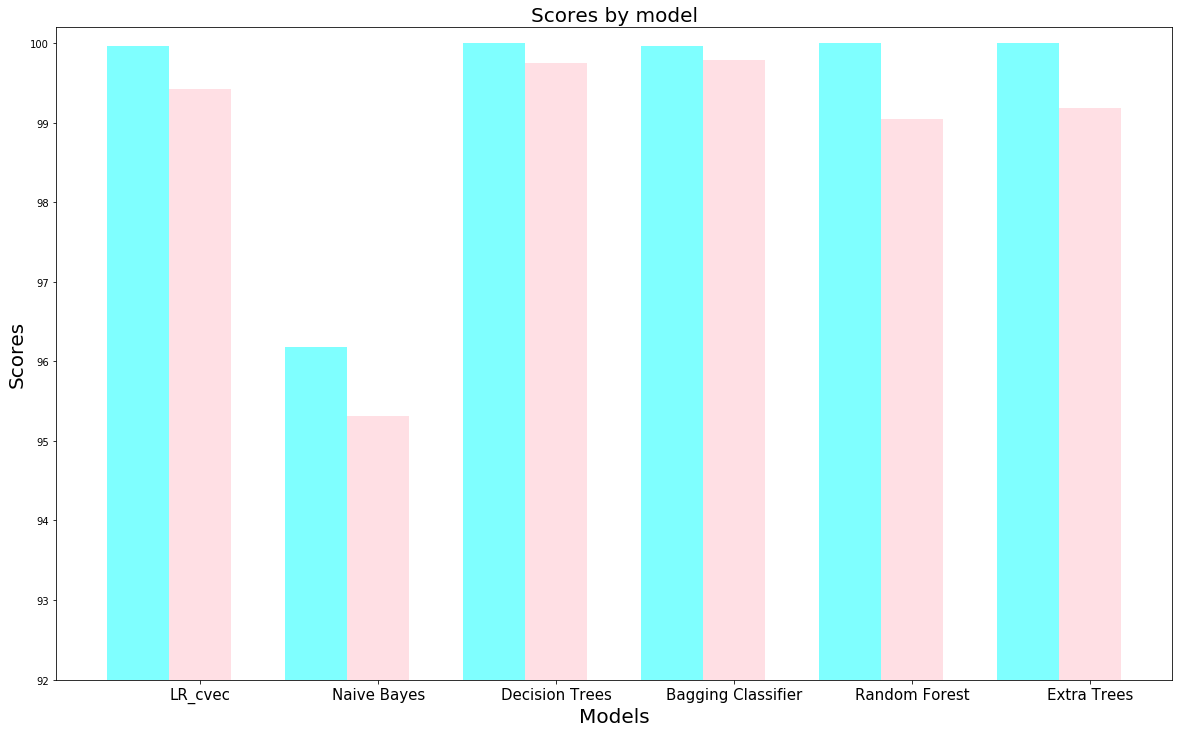

In [43]:
import matplotlib.pyplot as plt

%matplotlib inline


# create plot


fig, ax = plt.subplots(figsize=(20,12))

# data to plot
n_groups = len(scores_df.index)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.5

rects1 = plt.bar(index, scores_df['train'], bar_width,
alpha=opacity,
color='cyan',
label='Test')

rects2 = plt.bar(index + bar_width, scores_df['test'], bar_width,
alpha=opacity,
color='pink',
label='Test')

plt.xlabel('Models', fontsize=20)
plt.ylabel('Scores', fontsize=20)
plt.ylim(92,100.2)
plt.title('Scores by model', fontsize=20)
plt.xticks(index + bar_width, (scores_df.index), fontsize=15);



As we could see, we have not gotten any improvement on our training and testing accuracy scores in comparison with our Bagging classifier.

## 4. Conclusions ##
---

Taking into account the abundance of information available nowadays, it is of a paramount importance to be able to distinguish information that can be potentially useful. That can not be overestimated especially in connection with emergency mitigation tactics. Specifically, identifying currently closed/blocked streets when planning routes in an emergency situation needs to be done with the highest precision possible, hence we need to filter 'ham-spam' our input information from various sources.
Modeling of 'ham-spam' identification of Twitter posts as containing raw information for streets closures attempted above has brought us the following results:

**We could identify a Twitter post with accuracy of 0.9955 or 99,55% of correctly classified posts by means of using a Bagging Classifier with 11 estimators and other default parameters using CountVectorizer with max_features=5000, ngram_range=(1,2) and English stopwords**



In [44]:
#Saving our best model for future use
best_model = results_bag.best_estimator_

## 5. Test Run ##
---

Now it's time to use our best model for sorting tweets scrapped for our project illustration. These are tweets scrapped from the same channels within the last two weeks and stored in the file [new_data.csv](http://localhost:8888/edit/PROJECTS/project_5/project_5/datasets/new_data.csv).

In [46]:
#Loading our new tweets into DataFrame
new_df = pd.read_csv('../datasets/new_data.csv')
new_df.head()

,Unnamed: 0,username,tweet,date_posted
0,0,511njbt,Delays on George Washington Bridge westbound f...,2019-11-06 23:59:56+00:00
1,1,511njbt,Delays on George Washington Bridge westbound f...,2019-11-06 23:58:57+00:00
2,2,511njtpk,Crash on New Jersey Turnpike - Eastern Spur so...,2019-11-06 23:58:56+00:00
3,3,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00
4,4,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00


In [47]:
#Creatng our feature matrix
X_new= new_df['tweet']

In [48]:
#Missing values check
X_new.isna().sum()

0

In [49]:
#Running our model on new data, getting predictions and storing them in a new column
new_df['mark'] = best_model.predict(X_new)

#Initial predictions check
new_df['mark'].value_counts()

1    6360
0    1655
Name: mark, dtype: int64

In [50]:
#Preparing new DataFrame for future processing

future_processing = new_df[new_df['mark'] == 0]

In [51]:
#Consistency check
future_processing.head()

,Unnamed: 0,username,tweet,date_posted,mark
3,3,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00,0
4,4,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00,0
8,8,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:41:56+00:00,0
9,9,511nji76,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,2019-11-06 23:41:56+00:00,0
19,19,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:27:56+00:00,0


In [52]:
#Dropping technical column
future_processing.drop(columns='Unnamed: 0', inplace = True)

C:\Users\Fausto\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [53]:
#resetting index
future_processing.reset_index(drop = True, inplace = True)

In [54]:
#Final check
future_processing

,username,tweet,date_posted,mark
0,511nji295,Crash on I-295 southbound South of Exit 29 - U...,2019-11-06 23:56:56+00:00,0
1,511njace,"Construction, bridge painting on Atlantic City...",2019-11-06 23:52:57+00:00,0
2,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:41:56+00:00,0
3,511nji76,Crash on I-76 eastbound at Exit 2 - I-676 (Cam...,2019-11-06 23:41:56+00:00,0
4,511njtpk,Roadwork on New Jersey Turnpike inner roadway ...,2019-11-06 23:27:56+00:00,0
...,...,...,...,...
1650,NJTRANSIT_SBUS,Bus Route No. 413 to Camden will operate via H...,2019-10-24 11:54:40+00:00,0
1651,NJDOT_info,"UPDATE: Rt 38 EASTBOUND LANES REOPENED, WESTBO...",2019-10-24 11:31:46+00:00,0
1652,NJDOT_info,Rt 38 all lanes are closed and detoured in bot...,2019-10-24 11:05:43+00:00,0
1653,NJTRANSIT_SBUS,Bus Route Nos. 313/317/551 will operate on a d...,2019-10-24 00:34:20+00:00,0


In [55]:
#Saving into a csv file
future_processing.to_csv('../datasets/future_processing.csv')

---